In [1]:
import pandas as pd
import numpy as np
import re
import pickle
import seaborn as sns
from plotly.offline import init_notebook_mode, iplot
from wordcloud import WordCloud
import plotly.graph_objs as go
import matplotlib.pyplot as plt
import plotly.plotly as py
from plotly import tools
import IPython
from sklearn.preprocessing import LabelEncoder,MinMaxScaler,StandardScaler,OneHotEncoder
from sklearn.model_selection import cross_val_score,GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC 
from sklearn.ensemble import RandomForestClassifier
from sklearn.base import BaseEstimator
from sklearn.base import ClassifierMixin
from sklearn.ensemble import AdaBoostClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
from sklearn import metrics
import operator
import xgboost as xgb
from sklearn.neural_network import MLPClassifier
import lightgbm as lgb
from keras import Sequential
from keras.layers import Dense
import tensorflow as tf
from keras import backend as K
from keras.callbacks import EarlyStopping
from matplotlib import pyplot
from sklearn.decomposition import PCA
from keras import regularizers

init_notebook_mode(connected=True)

Using TensorFlow backend.


In [0]:
# with open('train_set.pkl', 'rb') as f:
#     data = pickle.load(f)
dateparse = lambda x: pd.datetime.strptime(x, '%d-%m-%y')
data=pd.read_csv('train.csv',parse_dates=['Date.of.Birth','DisbursalDate'], date_parser=dateparse)
testdata=pd.read_csv('test_bqCt9Pv.csv',parse_dates=['Date.of.Birth','DisbursalDate'], date_parser=dateparse)

In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 233154 entries, 0 to 233153
Data columns (total 41 columns):
UniqueID                               233154 non-null int64
disbursed_amount                       233154 non-null int64
asset_cost                             233154 non-null int64
ltv                                    233154 non-null float64
branch_id                              233154 non-null int64
supplier_id                            233154 non-null int64
manufacturer_id                        233154 non-null int64
Current_pincode_ID                     233154 non-null int64
Date.of.Birth                          233154 non-null datetime64[ns]
Employment.Type                        225493 non-null object
DisbursalDate                          233154 non-null datetime64[ns]
State_ID                               233154 non-null int64
Employee_code_ID                       233154 non-null int64
MobileNo_Avl_Flag                      233154 non-null int64
Aadhar_flag   

In [4]:
data.head()

UniqueID  disbursed_amount  asset_cost    ltv  branch_id  supplier_id  \
0    420825             50578       58400  89.55         67        22807   
1    537409             47145       65550  73.23         67        22807   
2    417566             53278       61360  89.63         67        22807   
3    624493             57513       66113  88.48         67        22807   
4    539055             52378       60300  88.39         67        22807   

   manufacturer_id  Current_pincode_ID Date.of.Birth Employment.Type  \
0               45                1441    1984-01-01        Salaried   
1               45                1502    1985-07-31   Self employed   
2               45                1497    1985-08-24   Self employed   
3               45                1501    1993-12-30   Self employed   
4               45                1495    1977-12-09   Self employed   

       ...      SEC.SANCTIONED.AMOUNT  SEC.DISBURSED.AMOUNT  \
0      ...                          0                     0   
1      ...                          0                     0   
2      ...                          0                     0   
3      ...                          0                     0   
4      ...                          0                     0   

   PRIMARY.INSTAL.AMT  SEC.INSTAL.AMT  NEW.ACCTS.IN.LAST.SIX.MONTHS  \
0                   0               0                             0   
1                1991               0                             0   
2                   0               0                             0   
3                  31               0                             0   
4                   0               0                             0   

   DELINQUENT.ACCTS.IN.LAST.SIX.MONTHS  AVERAGE.ACCT.AGE  \
0                                    0         0yrs 0mon   
1                                    1        1yrs 11mon   
2                                    0         0yrs 0mon   
3                                    0         0yrs 8mon   
4                                    0         0yrs 0mon   

   CREDIT.HISTORY.LENGTH  NO.OF_INQUIRIES  loan_default  
0              0yrs 0mon                0             0  
1             1yrs 11mon                0             1  
2              0yrs 0mon                0             0  
3              1yrs 3mon                1             1  
4              0yrs 0mon                1             1  

[5 rows x 41 columns]

In [5]:
data.columns

Index(['UniqueID', 'disbursed_amount', 'asset_cost', 'ltv', 'branch_id',
       'supplier_id', 'manufacturer_id', 'Current_pincode_ID', 'Date.of.Birth',
       'Employment.Type', 'DisbursalDate', 'State_ID', 'Employee_code_ID',
       'MobileNo_Avl_Flag', 'Aadhar_flag', 'PAN_flag', 'VoterID_flag',
       'Driving_flag', 'Passport_flag', 'PERFORM_CNS.SCORE',
       'PERFORM_CNS.SCORE.DESCRIPTION', 'PRI.NO.OF.ACCTS', 'PRI.ACTIVE.ACCTS',
       'PRI.OVERDUE.ACCTS', 'PRI.CURRENT.BALANCE', 'PRI.SANCTIONED.AMOUNT',
       'PRI.DISBURSED.AMOUNT', 'SEC.NO.OF.ACCTS', 'SEC.ACTIVE.ACCTS',
       'SEC.OVERDUE.ACCTS', 'SEC.CURRENT.BALANCE', 'SEC.SANCTIONED.AMOUNT',
       'SEC.DISBURSED.AMOUNT', 'PRIMARY.INSTAL.AMT', 'SEC.INSTAL.AMT',
       'NEW.ACCTS.IN.LAST.SIX.MONTHS', 'DELINQUENT.ACCTS.IN.LAST.SIX.MONTHS',
       'AVERAGE.ACCT.AGE', 'CREDIT.HISTORY.LENGTH', 'NO.OF_INQUIRIES',
       'loan_default'],
      dtype='object')

In [6]:
print("Creating the age column from date of birth and disbursal date")
data['Agecust']=((data['DisbursalDate']-data['Date.of.Birth'])/np.timedelta64(1, 'Y'))
data['Agecust'] =data['Agecust'].astype(int)

testdata['Agecust']=((testdata['DisbursalDate']-testdata['Date.of.Birth'])/np.timedelta64(1, 'Y'))
testdata['Agecust'] =testdata['Agecust'].astype(int)

Creating the age column from date of birth and disbursal date


In [7]:
#Converting the employment category

print("Checking for the null values in employment category\n")
print("Employment categories availabe",data['Employment.Type'].unique())
print("\n")
print("Checking for nans in employment category \n",data['Employment.Type'].isna().value_counts())

Checking for the null values in employment category

Employment categories availabe ['Salaried' 'Self employed' nan]


Checking for nans in employment category 
 False    225493
True       7661
Name: Employment.Type, dtype: int64


In [0]:
data['Employment.Type']=data['Employment.Type'].fillna('Unknown')
testdata['Employment.Type']=testdata['Employment.Type'].fillna('Unknown')

In [0]:
data['Employment.Type'] = data['Employment.Type'].astype('category')
cat_columns = data.select_dtypes(['category']).columns

testdata['Employment.Type'] = testdata['Employment.Type'].astype('category')
cat_columns = testdata.select_dtypes(['category']).columns

In [0]:
data[cat_columns] = data[cat_columns].apply(lambda x: x.cat.codes)

testdata[cat_columns] = testdata[cat_columns].apply(lambda x: x.cat.codes)

In [11]:
print("Get the unique score descriptions", data['PERFORM_CNS.SCORE.DESCRIPTION'].unique())

Get the unique score descriptions ['No Bureau History Available' 'I-Medium Risk' 'L-Very High Risk'
 'A-Very Low Risk' 'Not Scored: Not Enough Info available on the customer'
 'D-Very Low Risk' 'M-Very High Risk' 'B-Very Low Risk' 'C-Very Low Risk'
 'E-Low Risk' 'H-Medium Risk' 'F-Low Risk' 'K-High Risk'
 'Not Scored: No Activity seen on the customer (Inactive)'
 'Not Scored: Sufficient History Not Available'
 'Not Scored: No Updates available in last 36 months' 'G-Low Risk'
 'J-High Risk' 'Not Scored: Only a Guarantor'
 'Not Scored: More than 50 active Accounts found']


In [0]:
data['PERFORM_CNS.SCORE.DESCRIPTION']=data['PERFORM_CNS.SCORE.DESCRIPTION'].apply(lambda x: x.split('-')[0] if len(x.split('-'))>1 else 'Z')
testdata['PERFORM_CNS.SCORE.DESCRIPTION']=testdata['PERFORM_CNS.SCORE.DESCRIPTION'].apply(lambda x: x.split('-')[0] if len(x.split('-'))>1 else 'Z')

In [13]:
print("Score description lookup table")

bureaulookup={'A':1,'Z':0,'I':3,'L':5,'D':1,'M':5
            ,'B':1,'C':1,'E':2,'H':3,'F':2,'K':4,'G':2,'J':4}

data['PERFORM_CNS.SCORE.DESCRIPTION']=data['PERFORM_CNS.SCORE.DESCRIPTION'].apply(lambda x: bureaulookup[x] if x in bureaulookup.keys() else '')

testdata['PERFORM_CNS.SCORE.DESCRIPTION']=testdata['PERFORM_CNS.SCORE.DESCRIPTION'].apply(lambda x: bureaulookup[x] if x in bureaulookup.keys() else '')

Score description lookup table


In [14]:
data['PERFORM_CNS.SCORE.DESCRIPTION'].value_counts()

0    129785
1     50728
2     18294
3     12412
4     12025
5      9910
Name: PERFORM_CNS.SCORE.DESCRIPTION, dtype: int64

In [0]:
# supplierlabelencode=LabelEncoder()
# data['supplier_id']=supplierlabelencode.fit_transform(data['supplier_id'])
# testdata['supplier_id']=supplierlabelencode.fit_transform(testdata['supplier_id'])

**Creating year and month from credit history and average acct age**

In [0]:
data[['YEAR', 'MONTH']] = data['AVERAGE.ACCT.AGE'].str.replace('yrs ', ',').str.replace('mon', '').str.split(',', expand=True).astype(int)
data['ACC_AGE_MONTHS'] = data['YEAR'].astype(int)*12 + data['MONTH'].astype(int)
data.drop(['YEAR', 'MONTH', 'AVERAGE.ACCT.AGE'], axis=1, inplace=True)

testdata[['YEAR', 'MONTH']] = testdata['AVERAGE.ACCT.AGE'].str.replace('yrs ', ',').str.replace('mon', '').str.split(',', expand=True).astype(int)
testdata['ACC_AGE_MONTHS'] = testdata['YEAR'].astype(int)*12 + testdata['MONTH'].astype(int)
testdata.drop(['YEAR', 'MONTH', 'AVERAGE.ACCT.AGE'], axis=1, inplace=True)

In [0]:
data[['YEAR', 'MONTH']] = data['CREDIT.HISTORY.LENGTH'].str.replace('yrs ', ',').str.replace('mon', '').str.split(',', expand=True).astype(int)
data['FIRST_LOAN_MONTHS'] = data['YEAR'].astype(int)*12 + data['MONTH'].astype(int)
data.drop(['YEAR', 'MONTH', 'CREDIT.HISTORY.LENGTH'], axis=1, inplace=True)

testdata[['YEAR', 'MONTH']] = testdata['CREDIT.HISTORY.LENGTH'].str.replace('yrs ', ',').str.replace('mon', '').str.split(',', expand=True).astype(int)
testdata['FIRST_LOAN_MONTHS'] = testdata['YEAR'].astype(int)*12 + testdata['MONTH'].astype(int)
testdata.drop(['YEAR', 'MONTH', 'CREDIT.HISTORY.LENGTH'], axis=1, inplace=True)

**Creating the disbursal month and days column**

In [0]:
data['DisbursalMonth']=data['DisbursalDate'].apply(lambda x: x.month)
data['DisbursalDays']=data['DisbursalDate'].apply(lambda x: x.day)

testdata['DisbursalMonth']=testdata['DisbursalDate'].apply(lambda x: x.month)
testdata['DisbursalDays']=testdata['DisbursalDate'].apply(lambda x: x.day)

In [0]:
bins = [0, 10, 20, 35]
labels = [1,2,3]
data['DisbursalDays'] = pd.cut(data['DisbursalDays'], bins=bins, labels=labels)
data['DisbursalDays']=data['DisbursalDays'].astype(int)          
data.drop(['Date.of.Birth','DisbursalDate','UniqueID'],axis=1,inplace=True)

testdata['DisbursalDays'] = pd.cut(testdata['DisbursalDays'], bins=bins, labels=labels)
testdata['DisbursalDays']=testdata['DisbursalDays'].astype(int)          
testdata.drop(['Date.of.Birth','DisbursalDate'],axis=1,inplace=True)

(array([     0.,      0.,   1573.,  18148., 134960.,  43429.,  19280.,
          9201.,   2441.,   1310.]),
 array([  1000.,  15900.,  30800.,  45700.,  60600.,  75500.,  90400.,
        105300., 120200., 135100., 150000.]),
 <a list of 10 Patch objects>)

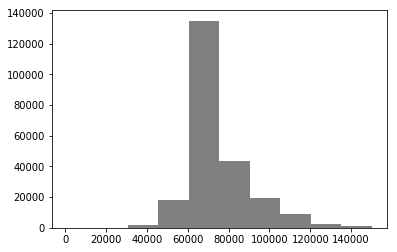

In [20]:
plt.hist(data['asset_cost'],range=[1000,150000],facecolor='gray', align='mid')

(array([1.7000e+01, 3.7700e+02, 1.6878e+05, 1.2573e+04, 7.8480e+03,
        4.6770e+03, 3.4750e+03, 2.5560e+03, 2.0910e+03, 1.8900e+03]),
 array([-50000., -25000.,      0.,  25000.,  50000.,  75000., 100000.,
        125000., 150000., 175000., 200000.]),
 <a list of 10 Patch objects>)

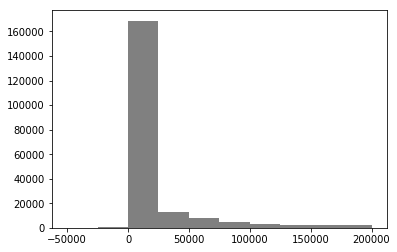

In [21]:
plt.hist(data['PRI.CURRENT.BALANCE'],range=[-50000,200000],facecolor='gray', align='mid')

**Normalisation of the disbursed amount and asset cost **

In [0]:
# '''Disbursed Amount '''

# scaler = MinMaxScaler()

# scaler.fit(data['disbursed_amount'].values.reshape(-1, 1))

# print(scaler.data_max_)

# data['disbursed_amount'] = scaler.transform(data['disbursed_amount'].values.reshape(-1, 1))
 

# '''Asset Cost '''
# assetscaler = MinMaxScaler()

# assetscaler.fit(data['asset_cost'].values.reshape(-1, 1))

# print(assetscaler.data_max_)

# data['asset_cost'] = assetscaler.transform(data['asset_cost'].values.reshape(-1, 1))

In [0]:
# '''Disbursed Amount '''

# testdata['disbursed_amount'] = scaler.transform(testdata['disbursed_amount'].values.reshape(-1, 1))
 
# '''Asset Cost '''

# testdata['asset_cost'] = assetscaler.transform(testdata['asset_cost'].values.reshape(-1, 1))

**Log transformation and normalizing the amount columns as it is highly skewed**

In [0]:
# balscaler=MinMaxScaler()

# prisecbal=["PRI.CURRENT.BALANCE","PRI.SANCTIONED.AMOUNT","PRI.DISBURSED.AMOUNT","SEC.CURRENT.BALANCE","SEC.SANCTIONED.AMOUNT","SEC.DISBURSED.AMOUNT",
#            "PRIMARY.INSTAL.AMT","SEC.INSTAL.AMT"]

# minvals=[-data[l].min()+1 if data[l].min()<0 else data[l].min()+1 for l in prisecbal]
# testminvals=[-testdata[l].min()+1 if testdata[l].min()<0 else testdata[l].min()+1 for l in prisecbal]


# data['PRI.CURRENT.BALANCE']=balscaler.fit_transform(np.log(data['PRI.CURRENT.BALANCE']+minvals[0]).values.reshape(-1, 1))
# testdata['PRI.CURRENT.BALANCE']=balscaler.transform(np.log(testdata['PRI.CURRENT.BALANCE']+testminvals[0]).values.reshape(-1, 1))


# data['PRI.SANCTIONED.AMOUNT']=balscaler.fit_transform(np.log(data['PRI.SANCTIONED.AMOUNT']+minvals[1]).values.reshape(-1, 1))
# testdata['PRI.SANCTIONED.AMOUNT']=balscaler.transform(np.log(testdata['PRI.SANCTIONED.AMOUNT']+testminvals[1]).values.reshape(-1, 1))

# data['PRI.DISBURSED.AMOUNT']=balscaler.fit_transform(np.log(data['PRI.DISBURSED.AMOUNT']+minvals[2]).values.reshape(-1, 1))
# testdata['PRI.DISBURSED.AMOUNT']=balscaler.transform(np.log(testdata['PRI.DISBURSED.AMOUNT']+testminvals[2]).values.reshape(-1, 1))

# data['SEC.CURRENT.BALANCE']=balscaler.fit_transform(np.log(data['SEC.CURRENT.BALANCE']+minvals[3]).values.reshape(-1, 1))
# testdata['SEC.CURRENT.BALANCE']=balscaler.transform(np.log(testdata['SEC.CURRENT.BALANCE']+testminvals[3]).values.reshape(-1, 1))

# data['SEC.SANCTIONED.AMOUNT']=balscaler.fit_transform(np.log(data['SEC.SANCTIONED.AMOUNT']+minvals[4]).values.reshape(-1, 1))
# testdata['SEC.SANCTIONED.AMOUNT']=balscaler.transform(np.log(testdata['SEC.SANCTIONED.AMOUNT']+testminvals[4]).values.reshape(-1, 1))

# data['SEC.DISBURSED.AMOUNT']=balscaler.fit_transform(np.log(data['SEC.DISBURSED.AMOUNT']+minvals[5]).values.reshape(-1, 1))
# testdata['SEC.DISBURSED.AMOUNT']=balscaler.transform(np.log(testdata['SEC.DISBURSED.AMOUNT']+testminvals[5]).values.reshape(-1, 1))

# data['PRIMARY.INSTAL.AMT']=balscaler.fit_transform(np.log(data['PRIMARY.INSTAL.AMT']+minvals[6]).values.reshape(-1, 1))
# testdata['PRIMARY.INSTAL.AMT']=balscaler.transform(np.log(testdata['PRIMARY.INSTAL.AMT']+testminvals[6]).values.reshape(-1, 1))

# data['SEC.INSTAL.AMT']=balscaler.fit_transform(np.log(data['SEC.INSTAL.AMT']+minvals[7]).values.reshape(-1, 1))
# testdata['SEC.INSTAL.AMT']=balscaler.transform(np.log(testdata['SEC.INSTAL.AMT']+testminvals[7]).values.reshape(-1, 1))

**Explolartory Data Analysis**

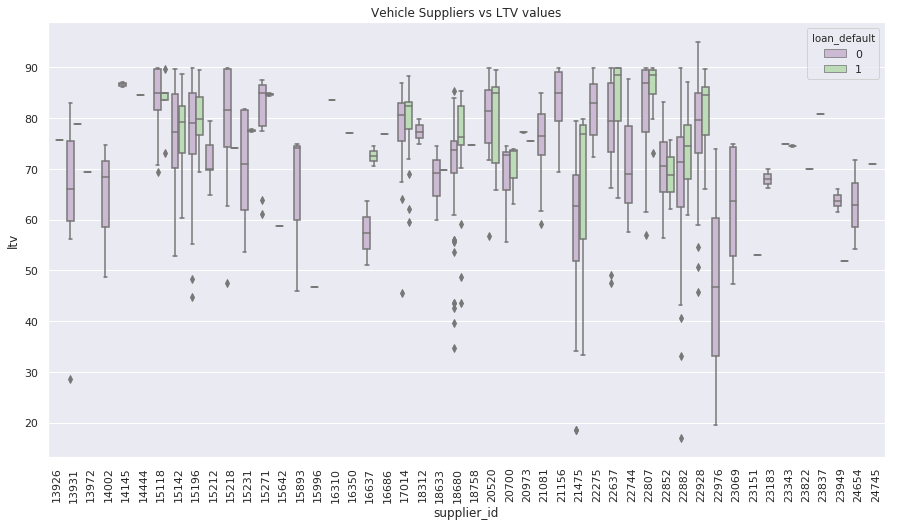

In [27]:
sns.set(rc={'figure.figsize':(15, 8)})
sns.boxplot(x="supplier_id", y="ltv", hue="loan_default",  palette="PRGn", data=data.head(1000))
plt.title("Vehicle Suppliers vs LTV values")
plt.xticks(rotation='vertical')
plt.show()

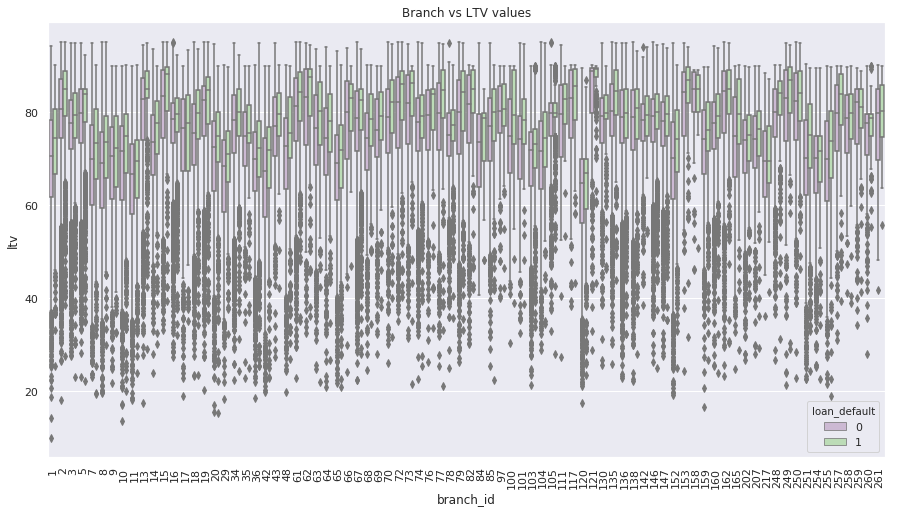

In [28]:
sns.set(rc={'figure.figsize':(15, 8)})
sns.boxplot(x="branch_id", y="ltv", hue="loan_default",  palette="PRGn", data=data)
plt.title("Branch vs LTV values")
plt.xticks(rotation='vertical')
plt.show()

In [0]:
def enable_plotly_in_cell():
  import IPython
  from plotly.offline import init_notebook_mode
  display(IPython.core.display.HTML('''
        <script src="/static/components/requirejs/require.js"></script>
  '''))
  init_notebook_mode(connected=False)

In [0]:
def _create_bubble_plots(col1, col2, aggcol, func, title, cs,data):
  
    tempdf = data.groupby([col1, col2]).agg({aggcol : func}).reset_index()
    tempdf[aggcol] = tempdf[aggcol].apply(lambda x : int(x))
    tempdf = tempdf.sort_values(aggcol, ascending=False)

    sizes = list(reversed([i for i in range(10,31)]))
    intervals = int(len(tempdf) / len(sizes))
    size_array = [9]*len(tempdf)
    
    st = 0
    for i, size in enumerate(sizes):
        for j in range(st, st+intervals):
            size_array[j] = size 
        st = st+intervals
    tempdf['size_n'] = size_array
  
    cols = list(tempdf['size_n'])
    enable_plotly_in_cell()
    trace1 = go.Scatter( x=tempdf[col1], y=tempdf[col2], mode='markers', text=tempdf[aggcol],
        marker=dict( size=tempdf.size_n, color=cols, colorscale=cs ))
    data = [trace1]
    layout = go.Layout(title=title)
    fig = go.Figure(data=data, layout=layout)
    iplot(fig)

In [31]:
_create_bubble_plots('State_ID', 'branch_id', 'disbursed_amount', 'mean', '', 'Picnic',data)

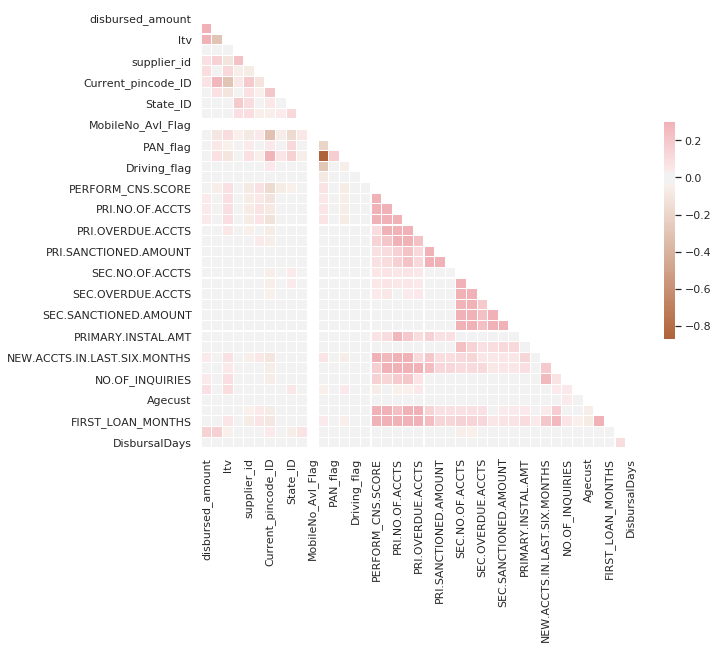

In [32]:
corr = data.corr()
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True
sns.set(style="white")

f, ax = plt.subplots(figsize=(10, 8))
cmap = sns.diverging_palette(30, 10, as_cmap=True)
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0, square=True, linewidths=.1, cbar_kws={"shrink": .5});

In [33]:
colmap = sns.light_palette("#7cc8ff", as_cmap=True)
pd.crosstab(data['Employment.Type'], data['loan_default']).style.background_gradient(cmap = colmap)

In [34]:
colmap = sns.light_palette("#7cc8ff", as_cmap=True)
pd.crosstab(data['Passport_flag'], data['loan_default']).style.background_gradient(cmap = colmap)

In [0]:
X=data.drop(['loan_default','MobileNo_Avl_Flag'],axis=1)
testX=testdata.drop(['MobileNo_Avl_Flag','UniqueID'],axis=1)

y=data['loan_default']

In [23]:
#New try
newpccomps=data[['PERFORM_CNS.SCORE',
       'PERFORM_CNS.SCORE.DESCRIPTION', 'PRI.NO.OF.ACCTS', 'PRI.ACTIVE.ACCTS',
       'PRI.OVERDUE.ACCTS', 'PRI.CURRENT.BALANCE', 'PRI.SANCTIONED.AMOUNT',
       'PRI.DISBURSED.AMOUNT'
       ]]

newpccompstest=testdata[['PERFORM_CNS.SCORE',
       'PERFORM_CNS.SCORE.DESCRIPTION', 'PRI.NO.OF.ACCTS', 'PRI.ACTIVE.ACCTS',
       'PRI.OVERDUE.ACCTS', 'PRI.CURRENT.BALANCE', 'PRI.SANCTIONED.AMOUNT',
       'PRI.DISBURSED.AMOUNT'
       ]]


pcascale=StandardScaler()

corrfeat=pcascale.fit_transform(newpccomps)
corrfeattest=pcascale.transform(newpccompstest)


pca = PCA(n_components=2)

principalComponents = pca.fit_transform(corrfeat)
principalComponentstest = pca.transform(corrfeattest)

principalDf = pd.DataFrame(data = principalComponents
             , columns = ['principal component 1', 'principal component 2'])
principalDftest = pd.DataFrame(data = principalComponentstest
             , columns = ['principal component 1', 'principal component 2'])



train = pd.concat([data.get(['disbursed_amount', 'asset_cost', 'ltv',
       'Employment.Type', 'Aadhar_flag', 'PAN_flag',
       'VoterID_flag', 'Driving_flag', 'Passport_flag','SEC.NO.OF.ACCTS', 'SEC.ACTIVE.ACCTS',
       'SEC.OVERDUE.ACCTS', 'SEC.CURRENT.BALANCE', 'SEC.SANCTIONED.AMOUNT',
       'SEC.DISBURSED.AMOUNT', 'PRIMARY.INSTAL.AMT', 'SEC.INSTAL.AMT',
       'NEW.ACCTS.IN.LAST.SIX.MONTHS', 'DELINQUENT.ACCTS.IN.LAST.SIX.MONTHS',
       'NO.OF_INQUIRIES', 'Agecust', 'ACC_AGE_MONTHS',
       'FIRST_LOAN_MONTHS', 'DisbursalMonth', 'DisbursalDays']),
        pd.get_dummies(data['branch_id'], prefix='branch'),pd.get_dummies(data['State_ID'], prefix='state'),principalDf],axis=1)

test = pd.concat([testdata.get(['disbursed_amount', 'asset_cost', 'ltv',
       'Employment.Type', 'Aadhar_flag', 'PAN_flag',
       'VoterID_flag', 'Driving_flag', 'Passport_flag','SEC.NO.OF.ACCTS', 'SEC.ACTIVE.ACCTS',
       'SEC.OVERDUE.ACCTS', 'SEC.CURRENT.BALANCE', 'SEC.SANCTIONED.AMOUNT',
       'SEC.DISBURSED.AMOUNT', 'PRIMARY.INSTAL.AMT', 'SEC.INSTAL.AMT',
       'NEW.ACCTS.IN.LAST.SIX.MONTHS', 'DELINQUENT.ACCTS.IN.LAST.SIX.MONTHS',
       'NO.OF_INQUIRIES', 'Agecust', 'ACC_AGE_MONTHS',
       'FIRST_LOAN_MONTHS', 'DisbursalMonth', 'DisbursalDays']),
        pd.get_dummies(testdata['branch_id'], prefix='branch'),pd.get_dummies(testdata['State_ID'], prefix='state'),
        principalDftest],axis=1)

/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/data.py:645: DataConversionWarning:

Data with input dtype int64 were all converted to float64 by StandardScaler.

/usr/local/lib/python3.6/dist-packages/sklearn/base.py:464: DataConversionWarning:

Data with input dtype int64 were all converted to float64 by StandardScaler.

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:17: DataConversionWarning:

Data with input dtype int64 were all converted to float64 by StandardScaler.



In [24]:
traincont=train[['disbursed_amount', 'asset_cost', 'ltv','SEC.CURRENT.BALANCE', 'SEC.SANCTIONED.AMOUNT',
       'SEC.DISBURSED.AMOUNT', 'PRIMARY.INSTAL.AMT', 'SEC.INSTAL.AMT',
       'NEW.ACCTS.IN.LAST.SIX.MONTHS']]

testcont=test[['disbursed_amount', 'asset_cost', 'ltv','SEC.CURRENT.BALANCE', 'SEC.SANCTIONED.AMOUNT',
       'SEC.DISBURSED.AMOUNT', 'PRIMARY.INSTAL.AMT', 'SEC.INSTAL.AMT',
       'NEW.ACCTS.IN.LAST.SIX.MONTHS']]


scalenew=StandardScaler()

newX=scalenew.fit_transform(traincont)
newtestX=scalenew.transform(testcont)

newdf=pd.DataFrame()
newdftest=pd.DataFrame()

newdf=newdf.append(newX.tolist())
newdftest=newdftest.append(newtestX.tolist())


finaltrain=pd.concat([data.get(['Employment.Type', 'Aadhar_flag', 'PAN_flag',
       'VoterID_flag', 'Driving_flag', 'Passport_flag','SEC.NO.OF.ACCTS', 'SEC.ACTIVE.ACCTS',
       'SEC.OVERDUE.ACCTS','DELINQUENT.ACCTS.IN.LAST.SIX.MONTHS',
       'NO.OF_INQUIRIES', 'Agecust', 'ACC_AGE_MONTHS',
       'FIRST_LOAN_MONTHS', 'DisbursalMonth', 'DisbursalDays']),
        pd.get_dummies(data['branch_id'], prefix='branch'),pd.get_dummies(data['State_ID'], prefix='state'),
        principalDf,newdf],axis=1)

finaltest=pd.concat([testdata.get(['Employment.Type', 'Aadhar_flag', 'PAN_flag',
       'VoterID_flag', 'Driving_flag', 'Passport_flag','SEC.NO.OF.ACCTS', 'SEC.ACTIVE.ACCTS',
       'SEC.OVERDUE.ACCTS','DELINQUENT.ACCTS.IN.LAST.SIX.MONTHS',
       'NO.OF_INQUIRIES', 'Agecust', 'ACC_AGE_MONTHS',
       'FIRST_LOAN_MONTHS', 'DisbursalMonth', 'DisbursalDays']),
        pd.get_dummies(testdata['branch_id'], prefix='branch'),
        pd.get_dummies(testdata['State_ID'], prefix='state'),
        principalDftest,newdftest],axis=1)


/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/data.py:645: DataConversionWarning:

Data with input dtype int64, float64 were all converted to float64 by StandardScaler.

/usr/local/lib/python3.6/dist-packages/sklearn/base.py:464: DataConversionWarning:

Data with input dtype int64, float64 were all converted to float64 by StandardScaler.

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:13: DataConversionWarning:

Data with input dtype int64, float64 were all converted to float64 by StandardScaler.



In [0]:

X_trainnew, X_validnew, y_trainnew, y_validnew = train_test_split(finaltrain, y, test_size=0.2, random_state=10)

In [26]:
print(finaltest.shape)
print(finaltrain.shape)

(112392, 131)
(233154, 131)


**Standardize check**

In [0]:
scalecheck=StandardScaler()

X=scalecheck.fit_transform(X)
testX=scalecheck.transform(testX)

/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/data.py:645: DataConversionWarning:

Data with input dtype int8, int64, float64 were all converted to float64 by StandardScaler.

/usr/local/lib/python3.6/dist-packages/sklearn/base.py:464: DataConversionWarning:

Data with input dtype int8, int64, float64 were all converted to float64 by StandardScaler.

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: DataConversionWarning:

Data with input dtype int8, int64, float64 were all converted to float64 by StandardScaler.



In [0]:
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2, random_state=10)

**Adaboost basecheck**

In [0]:

adaclass = AdaBoostClassifier(n_estimators=100,
                         learning_rate=1)

/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/data.py:645: DataConversionWarning:

Data with input dtype int8, int64, float64 were all converted to float64 by StandardScaler.

/usr/local/lib/python3.6/dist-packages/sklearn/base.py:464: DataConversionWarning:

Data with input dtype int8, int64, float64 were all converted to float64 by StandardScaler.

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: DataConversionWarning:

Data with input dtype int8, int64, float64 were all converted to float64 by StandardScaler.



In [0]:
# Fit
adaclass.fit(X_train, y_train)


AdaBoostClassifier(algorithm='SAMME.R', base_estimator=None, learning_rate=1,
          n_estimators=100, random_state=None)

In [0]:
# Predict
y_pred = adaclass.predict(X_valid)

# Accuracy
roc_auc_score(y_pred, y_valid)

0.6187891264771326

**XGboost base check**

In [0]:
def auc(m, train, test): 
    return (metrics.roc_auc_score(y_trainnew,m.predict_proba(train)[:,1]),
                            metrics.roc_auc_score(y_validnew,m.predict_proba(test)[:,1]))


# Parameter Tuning
# model = xgb.XGBClassifier()
# param_dist = {"max_depth": [10,30,50],
#               "min_child_weight" : [1,3,6],
#               "n_estimators": [200],
#               "learning_rate": [0.003,0.05, 0.001,0.16],}
# grid_search = GridSearchCV(model, param_grid=param_dist, cv = 3, 
#                                    verbose=10, n_jobs=-1)
# grid_search.fit(X, y)

# grid_search.best_estimator_


In [37]:
model = xgb.XGBClassifier(max_depth=30, min_child_weight=1,  n_estimators=100,
                          n_jobs=-1 , verbose=1,learning_rate=0.001)

model.fit(finaltrain,y)

#auc(model, X_trainnew, X_validnew)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.001, max_delta_step=0,
       max_depth=30, min_child_weight=1, missing=None, n_estimators=100,
       n_jobs=-1, nthread=None, objective='binary:logistic',
       random_state=0, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
       seed=None, silent=True, subsample=1, verbose=1)

In [38]:
submity=model.predict(finaltest)
#submity=xgb_model.predict(testimpfeatcols)
predictions = [round(value) for value in submity]

ValueError: ignored

In [39]:
submissiondf=pd.DataFrame()
submissiondf['UniqueID']=testdata['UniqueID']
submissiondf['loan_default']=predictions
submissiondf.to_csv('firstsubmission.csv',index=False)

NameError: ignored

In [0]:
def modelfit(alg, dtrain, predictors,useTrainCV=True, cv_folds=5, early_stopping_rounds=50):
    
    if useTrainCV:
        xgb_param = alg.get_xgb_params()
        xgtrain = xgb.DMatrix(dtrain[predictors].values, label=dtrain[target].values)
        cvresult = xgb.cv(xgb_param, xgtrain, num_boost_round=alg.get_params()['n_estimators'], nfold=cv_folds,
            metrics='auc', early_stopping_rounds=early_stopping_rounds, show_progress=False)
        alg.set_params(n_estimators=cvresult.shape[0])
    
    #Fit the algorithm on the data
    alg.fit(dtrain[predictors], dtrain['Disbursed'],eval_metric='auc')
        
    #Predict training set:
    dtrain_predictions = alg.predict(dtrain[predictors])
    dtrain_predprob = alg.predict_proba(dtrain[predictors])[:,1]
        
    #Print model report:
    print "\nModel Report"
    print "Accuracy : %.4g" % metrics.accuracy_score(dtrain['Disbursed'].values, dtrain_predictions)
    print "AUC Score (Train): %f" % metrics.roc_auc_score(dtrain['Disbursed'], dtrain_predprob)
                    
    feat_imp = pd.Series(alg.booster().get_fscore()).sort_values(ascending=False)
    feat_imp.plot(kind='bar', title='Feature Importances')
    plt.ylabel('Feature Importance Score')

**Keras base classifier** 

In [0]:
def auc(y_true, y_pred):
    auc = tf.metrics.auc(y_true, y_pred)[1]
    K.get_session().run(tf.local_variables_initializer())
    return auc

In [28]:
classifier = Sequential()

#First Hidden Layer
classifier.add(Dense(4, activation='relu', kernel_initializer='glorot_normal', input_dim=finaltrain.shape[1],kernel_regularizer=regularizers.l2(0.01)))

#Second  Hidden Layer
classifier.add(Dense(4, activation='relu', kernel_initializer='glorot_normal',kernel_regularizer=regularizers.l2(0.02)))

#Output Layer
classifier.add(Dense(1, activation='sigmoid', kernel_initializer='glorot_normal'))

#Compiling the neural network
classifier.compile(optimizer ='adam',loss='binary_crossentropy', metrics =[auc])

# simple early stopping
es = EarlyStopping(monitor='loss', mode='min', verbose=1,patience=5)



Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use tf.cast instead.
Instructions for updating:
Deprecated in favor of operator or tf.math.divide.


In [29]:
#Fitting the data to the training dataset
#classifier.fit(X_train,y_train, batch_size=64, epochs=100)

# fit model
history = classifier.fit(finaltrain, y,batch_size=128, epochs=1000, verbose=1, callbacks=[es])

Instructions for updating:
Use tf.cast instead.
Epoch 1/1000
233154/233154 [==============================] - 9s 39us/step - loss: 0.5491 - auc: 0.5329
Epoch 2/1000
233154/233154 [==============================] - 8s 33us/step - loss: 0.5234 - auc: 0.5566
Epoch 3/1000
233154/233154 [==============================] - 8s 34us/step - loss: 0.5211 - auc: 0.5639
Epoch 4/1000
233154/233154 [==============================] - 8s 34us/step - loss: 0.5192 - auc: 0.5725
Epoch 5/1000
233154/233154 [==============================] - 8s 34us/step - loss: 0.5175 - auc: 0.5792
Epoch 6/1000
233154/233154 [==============================] - 8s 33us/step - loss: 0.5160 - auc: 0.5852
Epoch 7/1000
233154/233154 [==============================] - 8s 35us/step - loss: 0.5150 - auc: 0.5901
Epoch 8/1000
233154/233154 [==============================] - 9s 37us/step - loss: 0.5143 - auc: 0.5941
Epoch 9/1000
233154/233154 [==============================] - 8s 36us/step - loss: 0.5138 - auc: 0.5972
Epoch 10/1000
23

Train: 0.610, Test: 0.610


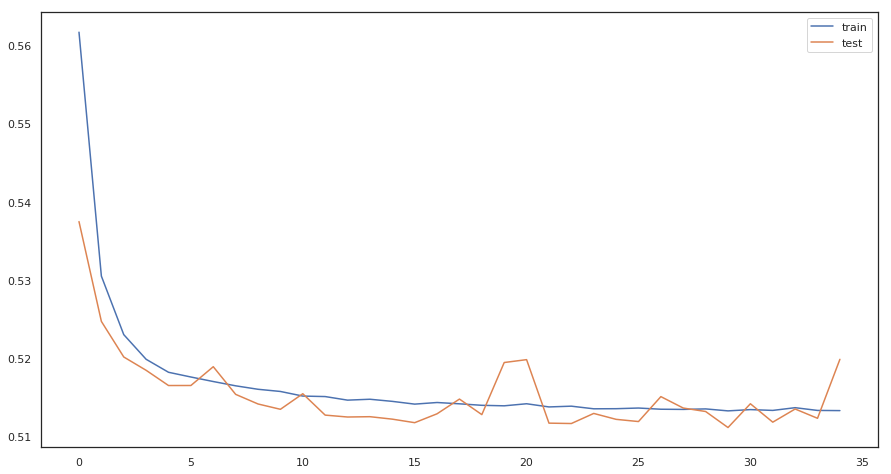

In [57]:
# evaluate the model
_, train_acc = classifier.evaluate(X_trainnew, y_trainnew, verbose=0)
_, test_acc = classifier.evaluate(X_validnew,y_validnew, verbose=0)
print('Train: %.3f, Test: %.3f' % (train_acc, test_acc))

# plot training history
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='test')
pyplot.legend()
pyplot.show()

In [0]:
y_pred=classifier.predict(finaltest)

#convert into binary values
for i in range(len(y_pred)):
    if y_pred[i]>=0.4:       # setting threshold to .5
       y_pred[i]=1
    else:  
       y_pred[i]=0
#roc_auc_score(y_valid,y_pred)

In [0]:
submissiondf=pd.DataFrame()
submissiondf['UniqueID']=testdata['UniqueID']
submissiondf['loan_default']=y_pred
submissiondf.to_csv('firstsubmission.csv',index=False)

**LGBM Check**

In [0]:
d_train = lgb.Dataset(X_trainnew, label=y_trainnew)
params = {}
params['learning_rate'] = 0.003
params['boosting_type'] = 'gbdt'
params['objective'] = 'binary'
params['metric'] = 'binary_logloss'
params['sub_feature'] = 0.5
params['num_leaves'] = 100
params['min_data'] = 100
params['max_depth'] = 30

# cate_features_name = ["branch_id","supplier_id","manufacturer_id","Current_pincode_ID","Employment.Type","State_ID","Employee_code_ID","Aadhar_flag",
#                       "PAN_flag","VoterID_flag","Driving_flag","Passport_flag","PERFORM_CNS.SCORE.DESCRIPTION","DisbursalMonth","DisbursalDays"
#                  ]

clf = lgb.train(params, d_train, 1500)#,categorical_feature=cate_features_name)

In [0]:
#Prediction
y_pred=clf.predict(X_validnew)

#convert into binary values
for i in range(len(y_pred)):
    if y_pred[i]>=.5:       # setting threshold to .5
       y_pred[i]=1
    else:  
       y_pred[i]=0

In [78]:
roc_auc_score(y_validnew,y_pred)

0.5033258243169667

In [0]:
submissiondf=pd.DataFrame()
submissiondf['UniqueID']=testdata['UniqueID']
submissiondf['loan_default']=y_pred
submissiondf.to_csv('firstsubmission.csv',index=False)

In [0]:
class NeuralNet:
  def __init__(self, nx, ny, hidden_sizes, algo='GD', init_method='random', activation_fn='sigmoid', leaky_slope=0.1):
    self.nx = nx
    self.ny = ny
    self.nh = len(hidden_sizes)
    self.sizes = [self.nx] + hidden_sizes + [self.ny]
    self.algo = algo
    self.init_method = init_method
    self.activation_fn = activation_fn
    self.leaky_slope = leaky_slope
    #to store all the parameter values for every epoch (to plot and observe if parameters are learning in every epoch)
    self.params_h = []
    self.total_neurons = sum(self.sizes)
    
    if(self.ny>2):
      self.type="multiclass"
    else:
      self.type="binary"
    
    self.params={}
    self.gradients={}
    self.update_params={}
    self.prev_update_params={}
    
    if(self.init_method=='random'):
      for i in range(self.nh+1):
        self.params['W'+str(i+1)] = np.random.randn(self.sizes[i], self.sizes[i+1])
        self.params['B'+str(i+1)] = np.zeros((1,self.sizes[i+1]))
    
    if(self.init_method=='zeros'):
      for i in range(self.nh+1):
        self.params['W'+str(i+1)] = np.zeros((self.sizes[i], self.sizes[i+1]))
        self.params['B'+str(i+1)] = np.zeros((1,self.sizes[i+1]))
    
    if(self.init_method=='xavier'):
      for i in range(self.nh+1):
        self.params['W'+str(i+1)] = np.random.randn(self.sizes[i], self.sizes[i+1])*np.sqrt(1/self.sizes[i])
        self.params['B'+str(i+1)] = np.zeros((1,self.sizes[i+1]))
      
    if(self.init_method=='he'):
      for i in range(self.nh+1):
        self.params['W'+str(i+1)] = np.random.randn(self.sizes[i], self.sizes[i+1])*np.sqrt(2/self.sizes[i])
        self.params['B'+str(i+1)] = np.zeros((1,self.sizes[i+1]))
    
    for i in range(self.nh+1):
      self.update_params['v_w'+str(i+1)] = 0
      self.update_params['v_b'+str(i+1)] = 0
      self.update_params['m_w'+str(i+1)] = 0
      self.update_params['m_b'+str(i+1)] = 0
      self.prev_update_params['v_w'+str(i+1)] = 0
      self.prev_update_params['v_b'+str(i+1)] = 0
       
  def activation(self, X):
    if(self.activation_fn=='sigmoid'):
      return(1.0/(1.0 + np.exp(-X)))
    elif(self.activation_fn=='tanh'):
      return(np.tanh(X))
    elif(self.activation_fn=='relu'):
      return(np.maximum(0,X))
    elif(self.activation_fn=='leaky_relu'):
      return(np.maximum(self.leaky_slope*X, X))
  
  def grad_activation(self, X):
    if(self.activation_fn=='sigmoid'):
      return (X * (1-X))
    elif(self.activation_fn=='tanh'):
      return(1-np.square(X))
    elif(self.activation_fn=='relu'):
      return(1.0*(X>0))
    elif(self.activation_fn=='leaky_relu'):
      d = np.zeros_like(X)
      d[X<=0] = self.leaky_slope
      d[X>0]  = 1
      return(d)
  
  def softmax(self, X):
    exps = np.exp(X)
    return(exps/np.sum(exps, axis=1).reshape(-1,1))
    
  def predict(self, X):
    Y_pred = self.forward_pass(X)
    if(self.type=='multiclass'):
      return(np.array(Y_pred).squeeze())
    else:
      return(np.array(Y_pred))
    
  def sigmoid(self, X):
    return(1.0/(1.0 + np.exp(-X)))
 
  def forward_pass(self, X, params=None):
    self.A = {}
    self.H = {}
    self.H[0] = X
    if(params is None):
      params = self.params
    for i in range(self.nh):
      self.A[i+1] = np.matmul(self.H[i], params['W'+str(i+1)]) + params['B'+str(i+1)]
      self.H[i+1] = self.activation(self.A[i+1])
    #compute last layer separately
    L = self.nh+1
    self.A[L] = np.matmul(self.H[L-1], self.params['W'+str(L)])
    if(self.type=='multiclass'):
      self.H[L] = self.softmax(self.A[L])
    else:
      self.H[L] = self.sigmoid(self.A[L])
    return(self.H[L])
  
  def grad(self, X, Y, params=None):
    if(params is None):
      params = self.params
    self.forward_pass(X, params)
    L = self.nh+1
    self.gradients['dA'+str(L)] = self.H[L] - Y
    for i in range(L,0,-1):
      self.gradients['dW'+str(i)] = np.matmul(self.H[i-1].T, self.gradients['dA'+str(i)])
      self.gradients['dB'+str(i)] = np.sum(self.gradients['dA'+str(i)], axis=0)
      self.gradients['dH'+str(i-1)] = np.matmul(self.gradients['dA'+str(i)], params['W'+str(i)].T)
      self.gradients['dA'+str(i-1)] = np.multiply(self.gradients['dH'+str(i-1)], self.grad_activation(self.H[i-1]))
  
  def fit(self, X, Y, epochs=100, eta=0.1, mini_batch_size=100, gamma=0.8, epsilon=1e-8, beta=0.9, beta1=0.9, beta2=0.9, display_loss=True):
    
    if(display_loss):
      loss = {}
    
    for epoch in tqdm_notebook(range(epochs), total=epochs, unit='epoch'):    
      m = X.shape[0]
      if(self.algo=='GD'):
        self.grad(X, Y)
        for i in range(self.nh+1):
          self.params['W'+str(i+1)] -= eta * self.gradients['dW'+str(i+1)]/m
          self.params['B'+str(i+1)] -= eta * self.gradients['dB'+str(i+1)]/m
      
      elif(self.algo=='minibatchgd'):
        for k in range(0, m, mini_batch_size):
          self.grad(X[k:k+mini_batch_size], Y[k:k+mini_batch_size])
          for i in range(self.nh+1):
            self.params['W'+str(i+1)] -= eta * self.gradients['dW'+str(i+1)]/mini_batch_size
            self.params['B'+str(i+1)] -= eta * self.gradients['dB'+str(i+1)]/mini_batch_size        
      
      elif(self.algo=='Momentum'):
        self.grad(X, Y)
        for i in range(self.nh+1):
          self.update_params['v_w'+str(i+1)] = gamma * self.update_params['v_w'+str(i+1)] + eta * self.gradients['dW'+str(i+1)]/m
          self.update_params['v_b'+str(i+1)] = gamma * self.update_params['v_b'+str(i+1)] + eta * self.gradients['dB'+str(i+1)]/m
          self.params['W'+str(i+1)] -= self.update_params['v_w'+str(i+1)]
          self.params['B'+str(i+1)] -= self.update_params['v_b'+str(i+1)]
      
      elif(self.algo=='NAG'):
        temp_params = {}
        for i in range(self.nh+1):
          self.update_params["v_w"+str(i+1)]=gamma*self.prev_update_params["v_w"+str(i+1)]
          self.update_params["v_b"+str(i+1)]=gamma*self.prev_update_params["v_b"+str(i+1)]
          temp_params["W"+str(i+1)]=self.params["W"+str(i+1)]-self.update_params["v_w"+str(i+1)]
          temp_params["B"+str(i+1)]=self.params["B"+str(i+1)]-self.update_params["v_b"+str(i+1)]
        self.grad(X,Y,temp_params)
        for i in range(self.nh+1):
          self.update_params["v_w"+str(i+1)] = gamma *self.update_params["v_w"+str(i+1)] + eta * (self.gradients["dW"+str(i+1)]/m)
          self.update_params["v_b"+str(i+1)] = gamma *self.update_params["v_b"+str(i+1)] + eta * (self.gradients["dB"+str(i+1)]/m)
          self.params["W"+str(i+1)] -= eta * (self.update_params["v_w"+str(i+1)])
          self.params["B"+str(i+1)] -= eta * (self.update_params["v_b"+str(i+1)]) 
        self.prev_update_params=self.update_params
        
      elif(self.algo=='AdaGrad'):
        self.grad(X, Y)
        for i in range(self.nh+1):
          self.update_params['v_w'+str(i+1)] += self.gradients['dW'+str(i+1)]**2
          self.update_params['v_b'+str(i+1)] += self.gradients['dB'+str(i+1)]**2
          self.params['W'+str(i+1)] -= eta/(np.sqrt(self.update_params['v_w'+str(i+1)])+epsilon)*self.gradients['dW'+str(i+1)]
          self.params['B'+str(i+1)] -= eta/(np.sqrt(self.update_params['v_b'+str(i+1)])+epsilon)*self.gradients['dB'+str(i+1)]
      
      elif(self.algo=='RMSProp'):
        self.grad(X, Y)
        for i in range(self.nh+1):
          self.update_params['v_w'+str(i+1)] = beta*self.update_params['v_w'+str(i+1)] + (1-beta)*self.gradients['dW'+str(i+1)]**2
          self.update_params['v_b'+str(i+1)] = beta*self.update_params['v_b'+str(i+1)] + (1-beta)*self.gradients['dB'+str(i+1)]**2
          self.params['W'+str(i+1)] -= eta/(np.sqrt(self.update_params['v_w'+str(i+1)])+epsilon)*self.gradients['dW'+str(i+1)]
          self.params['B'+str(i+1)] -= eta/(np.sqrt(self.update_params['v_b'+str(i+1)])+epsilon)*self.gradients['dB'+str(i+1)]
      
      elif(self.algo=='Adam'):
        self.grad(X,Y)
        num_updates=0
        for i in range(self.nh+1):
          num_updates+=1
          self.update_params['m_w'+str(i+1)] = beta1*self.update_params['m_w'+str(i+1)] + (1-beta1)*self.gradients['dW'+str(i+1)]
          self.update_params['m_b'+str(i+1)] = beta1*self.update_params['m_b'+str(i+1)] + (1-beta1)*self.gradients['dB'+str(i+1)]
          self.update_params['v_w'+str(i+1)] = beta2*self.update_params['v_w'+str(i+1)] + (1-beta2)*self.gradients['dW'+str(i+1)]**2
          self.update_params['v_b'+str(i+1)] = beta2*self.update_params['v_b'+str(i+1)] + (1-beta2)*self.gradients['dB'+str(i+1)]**2
          m_w_c = self.update_params['m_w'+str(i+1)] / (1 - np.power(beta1, num_updates))
          m_b_c = self.update_params['m_b'+str(i+1)] / (1 - np.power(beta1, num_updates))
          v_w_c = self.update_params['v_w'+str(i+1)] / (1 - np.power(beta1, num_updates))
          v_b_c = self.update_params['v_b'+str(i+1)] / (1 - np.power(beta1, num_updates))
          self.params['W'+str(i+1)] -= eta/(np.sqrt(v_w_c)+epsilon)*m_w_c
          self.params['B'+str(i+1)] -= eta/(np.sqrt(v_b_c)+epsilon)*m_b_c
          
      if(display_loss):
        Y_pred = self.predict(X)
        if(self.type=='multiclass'):
          loss[epoch] = log_loss(np.argmax(Y, axis=1), Y_pred)
        else:
          loss[epoch] = log_loss(Y, Y_pred)
        
        tmp_params_h = []
        for key in self.params.keys():
          concat_array = self.params[key].ravel()
          tmp_params_h = np.concatenate((tmp_params_h, concat_array))
        self.params_h.append(tmp_params_h)
      
    
    if(display_loss):
      plt.plot(loss.values(), '-o', markersize=5)
      plt.xlabel('Epochs')
      plt.ylabel('Log loss')
      plt.show()
      
      
      

In [0]:
y_reshaped = y.values.reshape(-1,1)

In [0]:
nnet = NeuralNet(39, 1, algo='Adam', activation_fn='leaky_relu', hidden_sizes=[5,10,15],init_method='xavier')

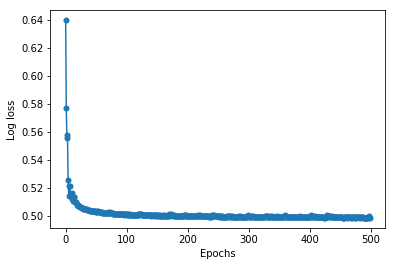

In [0]:
from tqdm import tqdm_notebook
from sklearn.metrics import log_loss
nnet.fit(X, y_reshaped,eta=.05,epochs=500)

In [0]:
pred=nnet.predict(X_valid)
updatepred=np.argmax(pred,axis=1)
#updatepred=[np.argmax(i) for i in pred]
#updatepred
roc_auc_score(y_valid,updatepred)

0.5

In [0]:
class EnsembleClassifier(BaseEstimator, ClassifierMixin):
    """ 
    Ensemble classifier for scikit-learn estimators.
        
    Parameters
    ----------
    
    clf : `iterable`
      A list of scikit-learn classifier objects.
    weights : `list` (default: `None`)
      If `None`, the majority rule voting will be applied to the predicted class labels.
        If a list of weights (`float` or `int`) is provided, the averaged raw probabilities (via `predict_proba`)
        will be used to determine the most confident class label.
      
    """
    def __init__(self, clfs, weights=None):
        self.clfs = clfs
        self.weights = weights

    def fit(self, X, y):
        """ 
        Fit the scikit-learn estimators.
        
        Parameters
        ----------

        X : numpy array, shape = [n_samples, n_features]
            Training data
        y : list or numpy array, shape = [n_samples]
            Class labels
      
        """
        for clf in self.clfs:
            clf.fit(X, y)
            
    def predict(self, X):
        """
        Parameters
        ----------

        X : numpy array, shape = [n_samples, n_features]
        
        Returns
        ----------
        
        maj : list or numpy array, shape = [n_samples]
            Predicted class labels by majority rule
        
        """
        
        self.classes_ = np.asarray([clf.predict(X) for clf in self.clfs])
        if self.weights:
            avg = self.predict_proba(X)

            maj = np.apply_along_axis(lambda x: max(enumerate(x), key=operator.itemgetter(1))[0], axis=1, arr=avg)
        
        else:
            maj = np.asarray([np.argmax(np.bincount(self.classes_[:,c])) for c in range(self.classes_.shape[1])])
        
        return maj
            
    def predict_proba(self, X):
        
        """
        Parameters
        ----------

        X : numpy array, shape = [n_samples, n_features]
        
        Returns
        ----------
        
        avg : list or numpy array, shape = [n_samples, n_probabilities]
            Weighted average probability for each class per sample.
        
        """
        self.probas_ = [clf.predict_proba(X) for clf in self.clfs]
      
        avg = np.average(self.probas_, axis=0, weights=self.weights)
        
        return avg

In [0]:
np.random.seed(123)

df = pd.DataFrame(columns=('w1', 'w2', 'mean', 'std'))

i = 0
for w1 in range(1,4):
    for w2 in range(1,4):
            
            if len(set((w1,w2))) == 1: # skip if all weights are equal
                continue
            
            eclf = EnsembleClassifier(clfs=[clf1, clf2], weights=[w1,w2])
            scores = cross_val_score(       estimator=eclf,
                                            X=X, 
                                            y=y, 
                                            cv=5, 
                                            scoring='roc_auc',
                                            n_jobs=1)
            
            df.loc[i] = [w1, w2, scores.mean(), scores.std()]
            i += 1
            
df.sort_values(['mean', 'std'], ascending=False)

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:433: FutureWarning:

Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.

/usr/local/lib/python3.6/dist-packages/sklearn/ensemble/forest.py:246: FutureWarning:

The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:433: FutureWarning:

Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.

/usr/local/lib/python3.6/dist-packages/sklearn/ensemble/forest.py:246: FutureWarning:

The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:433: FutureWarning:

Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.

/usr/local/lib/python3.6/dist-packages/sklearn/ensemble/forest.py:246: FutureWarning:

The 

TypeError: ignored